In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.stats import norm
import chess

In [2]:
moves_df = pd.read_csv("../Data/moves_df.csv")
clean_df = pd.read_csv("../Data/clean_df.csv")

In [3]:
moves_df.head()

,game_index,moves,evaluation,fen,zobrist_key
0,0,e2e4,35,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,9384546495678726550
1,0,e7e5,48,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...,595762792459712928
2,0,g1f3,111,rnbqkbnr/pppp1ppp/8/4p3/4P3/5N2/PPPP1PPP/RNBQK...,15213300192948443293
3,0,b8c6,47,r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNB...,8704797333742910878
4,0,f1b5,52,r1bqkbnr/pppp1ppp/2n5/1B2p3/4P3/5N2/PPPP1PPP/R...,5409798013178080797


In [4]:
clean_df.head()


,result,white_elo,black_elo,# moves,moves
0,1-0,2851,-1,67,W1.d4 B1.d5 W2.c4 B2.e6 W3.Nc3 B3.Nf6 W4.cxd5...
1,1-0,2851,-1,53,W1.e4 B1.d5 W2.exd5 B2.Qxd5 W3.Nc3 B3.Qa5 W4....
2,1-0,2851,-1,57,W1.e4 B1.e5 W2.Nf3 B2.Nc6 W3.Bc4 B3.Bc5 W4.c3...
3,1-0,2851,-1,49,W1.e4 B1.d5 W2.exd5 B2.Qxd5 W3.Nc3 B3.Qa5 W4....
4,1/2-1/2,2851,2633,97,W1.e4 B1.e5 W2.Nf3 B2.Nc6 W3.Bb5 B3.a6 W4.Ba4...


In [5]:
moves_df_reduc = moves_df[['game_index', 'moves', 'fen']]

In [6]:
clean_df_moves = clean_df['# moves']

### Move statistics

In [7]:
CapturedWhite = []
CapturedBlack = []
ListeWhite = ['P', 'T', 'C', 'F', 'K', 'Q']
ListeBlack = ['p', 't', 'c', 'f', 'k', 'q']

In [8]:
# on crée un dictionnaire où chaque case de l'échiquier correspond à un entier
dict_moves = {}
for square_num in range(1, 9):
    for square_letter in range(8):
        square = chr(ord('a') + square_letter) + str(square_num)
        dict_moves[square] = 8*(square_num-1)+square_letter
        
#On crée un disctionnaire qui fera office de compteur d'utilisation des pièces
dict_usecount = {'P': 0, 'T' : 0, 'C' :0, 'F' : 0, 'K' : 0, 'Q': 0, 'p' : 0, 't' : 0, 'c' :0, 'f' : 0, 'k' : 0, 'q': 0}

In [9]:
nb_total_games = moves_df.game_index.iloc[-1]

In [10]:
def piece_to_string(piece):
    str_piece = str(piece)
    lower_case = str_piece.islower()
    if str_piece.lower() in ['p', 'q', 'k']:
        return str_piece #meme lettre en francais et en anglais
    if str_piece.lower() == 'r': #case de la tour
        return 't' if lower_case else 'T'
    if str_piece.lower() == 'n':
        return 'c' if lower_case else 'C'
    if str_piece.lower() == 'b':
        return 'f' if lower_case else 'F'
    
    return 'None'

In [16]:
nb_moves_precedents = 0
for j in tqdm(range(nb_total_games)):   
    #on commence par grouper les coups pour chaque partie
    moves = [] #p est la liste de tous les coups de la partie j
    for k in range(nb_moves_precedents, len(moves_df_reduc)):
        if moves_df_reduc.loc[k, 'game_index'] == j:
            moves.append(moves_df_reduc.loc[k,'moves'])
        if moves_df_reduc.loc[k, 'game_index'] > j:
            break #la partie j est terminée donc on arrête la boucle
        
    board = chess.Board()
    for i in range(len(moves)):
        
        case_depart = moves[i][:2]
        case_arrivee = moves[i][2:4]
        piece_case_depart_board = board.piece_at(dict_moves[case_depart])
        piece_case_arrivee_board = board.piece_at(dict_moves[case_arrivee])
        piece_case_depart = piece_to_string(piece_case_depart_board)
        piece_case_arrivee = piece_to_string(piece_case_arrivee_board)
        
        #Pour le barchart représentant l'utilisation des pièces
        if piece_case_depart != 'None':
            dict_usecount[piece_case_depart] += 1
        
            
        #Pour les heatmaps concernant les captures de pièces
        
        if piece_case_arrivee in ListeWhite:
            CapturedWhite.append([j, case_arrivee, piece_case_arrivee, piece_case_depart])
        if piece_case_arrivee in ListeBlack:
            CapturedBlack.append([j, case_arrivee, piece_case_arrivee, piece_case_depart])
        
        board.push_uci(moves[i])
        
        
        
    nb_moves_precedents += len(moves) #on garde en memoire le nb de coups des parties deja analysees pour acceler le processus
                                      #de recherche des coups des parties

100%|█████████████████████████████████████████████████████████████████████████| 118318/118318 [09:34<00:00, 205.98it/s]


In [9]:
print(len(CapturedWhite))

818092


## Utilisation des différentes pièces

#### Nombre de coups par partie

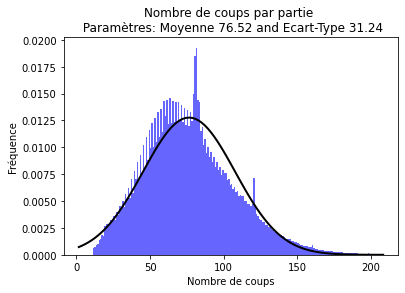

In [17]:
#Calcul des paramètres de la distribution normale de clean_df_moves
# mean and standard deviation
mu, std = norm.fit(clean_df_moves) 
bins = np.arange(min(clean_df_moves), 200, 1)
# Plot l'histogramme
plt.hist(clean_df_moves, bins, density=True, alpha=0.6, color='b')
  
# Plot la densité 
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
  
plt.plot(x, p, 'k', linewidth=2)
title = "Nombre de coups par partie \n Paramètres: Moyenne {:.2f} and Ecart-Type {:.2f}".format(mu, std)
plt.title(title)
plt.ylabel('Fréquence')

plt.xlabel('Nombre de coups')

  
plt.show()


#### Utilisation des différentes pièces

<AxesSubplot:title={'center':'Utilisation des différentes pièces'}, xlabel='Couleur'>

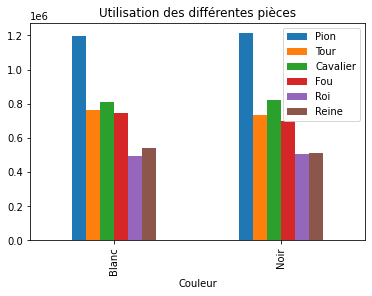

In [18]:
df_usecount = pd.DataFrame([['Blanc', dict_usecount['P'], dict_usecount['T'], dict_usecount['C'], dict_usecount['F'], dict_usecount['K'], dict_usecount['Q']], ['Noir', dict_usecount['p'], dict_usecount['t'], dict_usecount['c'], dict_usecount['f'], dict_usecount['k'], dict_usecount['q']]],
                  columns=['Couleur', 'Pion', 'Tour', 'Cavalier', 'Fou', 'Roi', 'Reine'])

df_usecount.plot(x='Couleur',
        kind='bar',
        stacked=False,
        title='Utilisation des différentes pièces')


## Heatmaps des résultats

#### Captures des pièces blanches

In [19]:
#représentation de capture white sous forme dataframe et groupby
df_White = pd.DataFrame.from_records(CapturedWhite)
df_capturedWhite = df_White[[2, 3]]
df_capturedWhite = df_capturedWhite.rename(columns = { 2 : 'White captured', 3 : 'Black capturing'})

Text(0.5, 42.0, 'Pièce capturée(Blanc)')

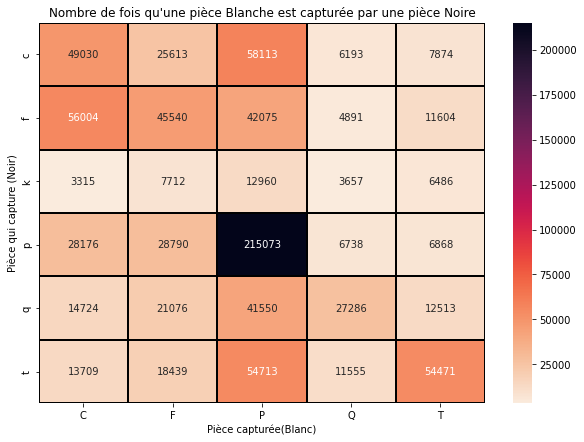

In [20]:
#heatmap du nombre de fois qu'une pièce blanche est capturée par une pièce noire
fig = plt.figure(figsize=(10,7))

df_capturedWhite = df_capturedWhite.groupby(['White captured', 'Black capturing']).size().reset_index(name='count')
heatmapWhitecaptured = sns.heatmap(df_capturedWhite.pivot(index='Black capturing',
                                    columns='White captured',values='count'),
                                   annot=True,cbar=True,cmap='rocket_r', linewidth = .01, 
                                   linecolor = 'black', 
                                   fmt = '.0f')
heatmapWhitecaptured.set_title("Nombre de fois qu'une pièce Blanche est capturée par une pièce Noire")
heatmapWhitecaptured.set_ylabel('Pièce qui capture (Noir)')
heatmapWhitecaptured.set_xlabel('Pièce capturée(Blanc)')

#### Captures des pièces noires

In [21]:
#représentation de capture black sous forme dataframe et groupby
df_Black = pd.DataFrame.from_records(CapturedBlack)
df_capturedBlack = df_Black[[2, 3]]
df_capturedBlack = df_capturedBlack.rename(columns = { 2 : 'Black captured', 3 : 'White capturing'})

Text(0.5, 42.0, 'Pièce capturée (Noir)')

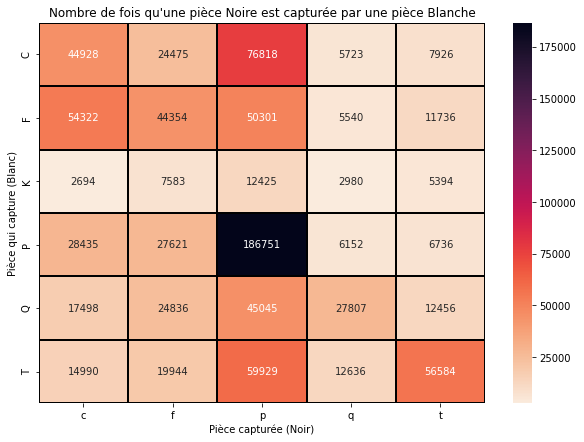

In [22]:
#heatmap du nombre de fois qu'une pièce noire est capturée par une pièce blanche
fig = plt.figure(figsize=(10,7))

df_capturedBlack = df_capturedBlack.groupby(['Black captured', 'White capturing']).size().reset_index(name='count')
heatmapBlackcaptured = sns.heatmap(df_capturedBlack.pivot(index='White capturing',columns='Black captured',values='count'),
                                   annot=True,cbar=True,cmap='rocket_r', linewidth = .01, 
                                   linecolor = 'black', fmt = '.0f')
heatmapBlackcaptured.set_title("Nombre de fois qu'une pièce Noire est capturée par une pièce Blanche")
heatmapBlackcaptured.set_ylabel('Pièce qui capture (Blanc)')
heatmapBlackcaptured.set_xlabel('Pièce capturée (Noir)')

#### Représentation des captures par case de l'échiquier

In [23]:
df_White_Position = df_White[[1]].rename(columns = {1 : 'coord'})
df_Black_Position = df_Black[[1]].rename(columns = {1 :'coord'})
df_White_Position = df_White_Position.groupby(['coord']).size().reset_index(name='count')
df_Black_Position = df_Black_Position.groupby(['coord']).size().reset_index(name='count')

In [24]:
df_Position = pd.merge(df_White_Position, df_Black_Position, how = 'outer', on='coord')
df_Position['count_x'] = df_Position['count_x'].replace(np.NaN, 0)
df_Position['count_y'] = df_Position['count_y'].replace(np.NaN, 0)
count = df_Position['count_x'] + df_Position['count_y']

In [25]:
df_Position = df_Position.assign(count = count)
df_Position = df_Position[['coord', 'count']]
df_Position['coord_lettre'] = df_Position['coord'].str[0]
df_Position['coord_chiffre'] = df_Position['coord'].str[1]
df_Position = df_Position[['count', 'coord_lettre', 'coord_chiffre']]

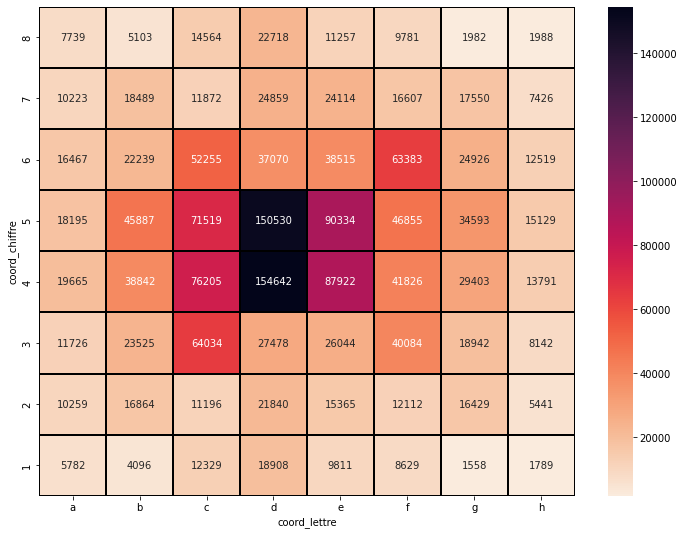

In [26]:
#heatmap des cases sur lesquelles on a le plus de captures de pièce
fig = plt.figure(figsize=(12,9))

heatmapPosition = sns.heatmap(df_Position.pivot(index='coord_chiffre',columns='coord_lettre',values='count'), 
                              annot=True,cbar=True,cmap='rocket_r', linewidth = .01, 
                              linecolor = 'black', fmt='d')
heatmapPosition.invert_yaxis()